In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from scipy.integrate import solve_ivp

In [ ]:
# Class definition and associated functions
class CSTR_RL_Env(gym.Env):
    """
    Two-CSTRs in series (NO DELAY): Effluent of Reactor-1 becomes influent of Reactor-2 instantly.

    Parameters are passed as a single vector X:
    #X = [V1, V2, C_in, half_life, HRT_min, HRT_max, C_limit,
                C_exceed_penalty, alpha, beta, dt, obs_noise]
    """
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, X):
        super().__init__()
        # V is split into V1 and V2
        self.V1 = float(X[0])
        self.V2 = float(X[1])
        self.Vt = self.V1 + self.V2  # total volume
        self.C_in = float(X[2])
        self.half_life = float(X[3])
        self.HRT_min = float(X[4])
        self.HRT_max = float(X[5])
        self.C_limit = float(X[6])
        self.C_exceed_penalty = float(X[7])
        self.alpha = float(X[8])
        self.beta = float(X[9])
        self.dt = float(X[10])
        self.obs_noise = float(X[11])

        # --- Decay constant k ---
        self.k = np.log(2.0) / max(self.half_life, 1e-12)

        # Flow bounds based on TOTAL HRT constraint using total volume
        self.Q_min = self.Vt / self.HRT_max
        self.Q_max = self.Vt / self.HRT_min
        # --------------------------------------------------

        # --- Gym spaces ---
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation is now [C1, C2]
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0], dtype=np.float32),
            high=np.array([self.C_in * 2.0, self.C_in * 2.0], dtype=np.float32)
        )

        # Internal state: two reactor concentrations
        self.C1 = None
        self.C2 = None

        self.current_step = 0

        self.seed(42)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, *, seed=None, options=None):
        self.current_step = 0
        self.C1 = float(self.C_in)
        self.C2 = float(self.C_in)
        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.array([self.C1, self.C2], dtype=np.float32)
        if self.obs_noise > 0:
            obs += self.np_random.normal(loc=0.0, scale=self.obs_noise, size=(2,))
        return np.clip(obs, self.observation_space.low, self.observation_space.high)

    def _ode_rhs_series(self, t, y, Q, C_in_step):
        C1, C2 = y
        dC1 = -self.k * C1 - (Q / self.V1) * (C1 - C_in_step)
        dC2 = -self.k * C2 - (Q / self.V2) * (C2 - C1)
        return [dC1, dC2]

    def step(self, action):
        # ------ Action -------
        a = float(np.clip(action, self.action_space.low, self.action_space.high).item())
        Q = self.Q_min + a * (self.Q_max - self.Q_min)

        # Total HRT = total volume / flow
        HRT_total = self.Vt / Q
        HRT1 = self.V1 / Q
        HRT2 = self.V2 / Q

        # --- Random influent fluctuation ±25% ---
        C_in_step = self.C_in * (1 + self.np_random.uniform(-0.25, 0.25))

        # Integration over dt
        sol = solve_ivp(
            fun=lambda t, y: self._ode_rhs_series(t, y, Q, C_in_step),
            t_span=(0.0, self.dt),
            y0=[self.C1, self.C2],
            method="RK45",
            atol=1e-8,
            rtol=1e-6
        )

        prev_C1, prev_C2 = self.C1, self.C2
        self.C1 = max(float(sol.y[0, -1]), 0.0)
        self.C2 = max(float(sol.y[1, -1]), 0.0)
        self.current_step += 1

        # ---------- Reward Structure --------------
        reward_conc = -self.alpha * self.C2
        reward_throughput = -self.beta * (HRT_total - self.HRT_min)

        exceedance = max(0.0, self.C2 - self.C_limit)
        reward_exceed = -self.C_exceed_penalty * exceedance

        reward = reward_conc + reward_throughput + reward_exceed

        done = False
        truncated = False

        info = {
            "C1": self.C1,
            "C2": self.C2,
            "prev_C1": prev_C1,
            "prev_C2": prev_C2,
            "Q": Q,
            "HRT_total": HRT_total,
            "HRT1": HRT1,
            "HRT2": HRT2,
            "C_limit": self.C_limit,
            "C_in_step": C_in_step,
            "exceedance": exceedance,
            "step": self.current_step
        }

        return self._get_obs(), float(reward), bool(done), bool(truncated), info

    def render(self, mode="human"):
        print(f"Step {self.current_step}: C1={self.C1:.4f}, C2={self.C2:.4f}")

    def close(self):
        pass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Simulation parameters ----------------
dt = 0.5               # hours
days = 7
total_steps = int(days * 24 / dt)

# ---------------- Env parameters ----------------
# X = [V1, V2, C_in, half_life, HRT_min, HRT_max, C_limit, penalty, alpha, beta, dt, obs_noise]
X = [600, 400, 100, 2.75, 3, 6, 50, 200, 1, 5, dt, 0.1]
env = CSTR_RL_Env(X)

#Reset Environment
obs, _ = env.reset()

# ---------------- History buffers----------------
time = np.arange(total_steps) * dt
C1_values = np.zeros(total_steps)
C2_values = np.zeros(total_steps)     # FINAL effluent
Q_values  = np.zeros(total_steps)
HRT_total_values = np.zeros(total_steps)
HRT1_values = np.zeros(total_steps)
HRT2_values = np.zeros(total_steps)
reward_values = np.zeros(total_steps)

# ---------------- Run simulation ----------------
for t in range(total_steps):
    action = env.action_space.sample()

    obs, reward, done, truncated, info = env.step(action)

    # store data
    C1_values[t] = info["C1"]
    C2_values[t] = info["C2"]
    Q_values[t]  = info["Q"]
    HRT_total_values[t] = info["HRT_total"]
    HRT1_values[t] = info["HRT1"]
    HRT2_values[t] = info["HRT2"]
    reward_values[t] = reward

    if done or truncated:
        break

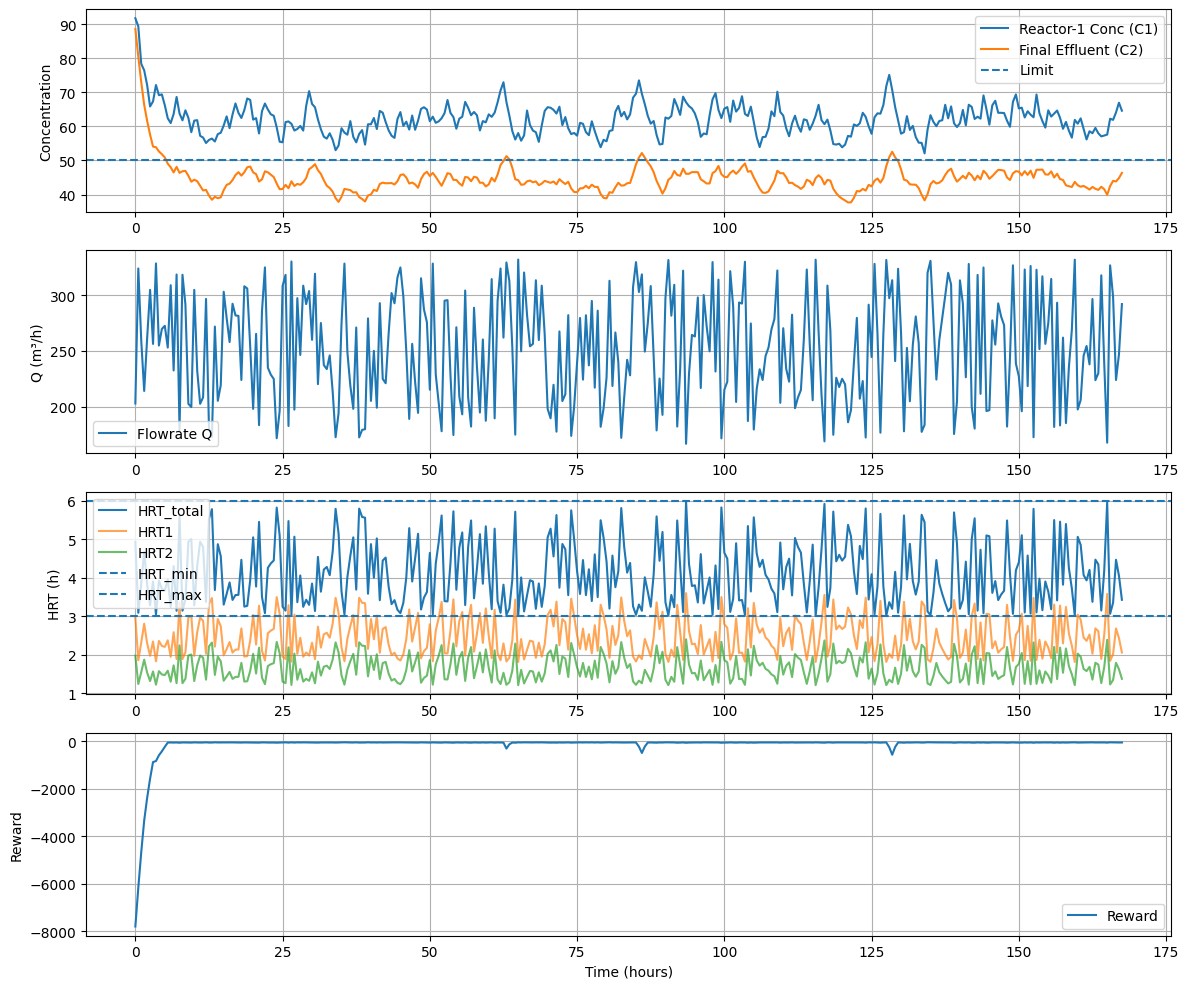

In [ ]:
plt.figure(figsize=(12, 10))

# 1. Concentrations
plt.subplot(4, 1, 1)
plt.plot(time, C1_values, label="Reactor-1 Conc (C1)")
plt.plot(time, C2_values, label="Final Effluent (C2)")
plt.axhline(env.C_limit, linestyle="--", label="Limit")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)

# 2. Flow Q
plt.subplot(4, 1, 2)
plt.plot(time, Q_values, label="Flowrate Q")
plt.ylabel("Q (m³/h)")
plt.legend()
plt.grid(True)

# 3. HRTs
plt.subplot(4, 1, 3)
plt.plot(time, HRT_total_values, label="HRT_total")
plt.plot(time, HRT1_values, label="HRT1", alpha=0.7)
plt.plot(time, HRT2_values, label="HRT2", alpha=0.7)
plt.axhline(env.HRT_min, linestyle="--", label="HRT_min")
plt.axhline(env.HRT_max, linestyle="--", label="HRT_max")
plt.ylabel("HRT (h)")
plt.legend()
plt.grid(True)

# 4. Reward
plt.subplot(4, 1, 4)
plt.plot(time, reward_values, label="Reward")
plt.xlabel("Time (hours)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()